In [1]:
import sys

from Trajectory import Trajectory
sys.path.append('..')
import numpy as np
from scipy.io import savemat
from matplotlib.pyplot import *
from gui.TrajectoryFrame import TypePolynomialFlatness, TypeOperatingPoint

In [39]:
traj_planner = TypeOperatingPoint()
for angle in range(-20, 25, 5):
    traj_planner.elevation = angle
    traj_planner.travel = 0
    trajectory = traj_planner.generate()
    savemat(f"../matlab/static_e{angle}.mat", trajectory.to_dict())

In [13]:
# Benchmarking Trajektorie
traj_planner = TypePolynomialFlatness()
traj_planner.elevation_start = -10
traj_planner.elevation_end = 10
traj_planner.travel_start = 0
traj_planner.travel_end = 120
traj_planner.t_end = 20
trajectory = traj_planner.generate()
savemat(f"../matlab/e_-10_10_l_0_120_t_20.mat", traj_planner.generate().to_dict())

traj_planner.t_end = 15
savemat(f"../matlab/e_-10_10_l_0_120_t_15.mat", traj_planner.generate().to_dict())

traj_planner.t_end = 10
savemat(f"../matlab/e_-10_10_l_0_120_t_10.mat", traj_planner.generate().to_dict())

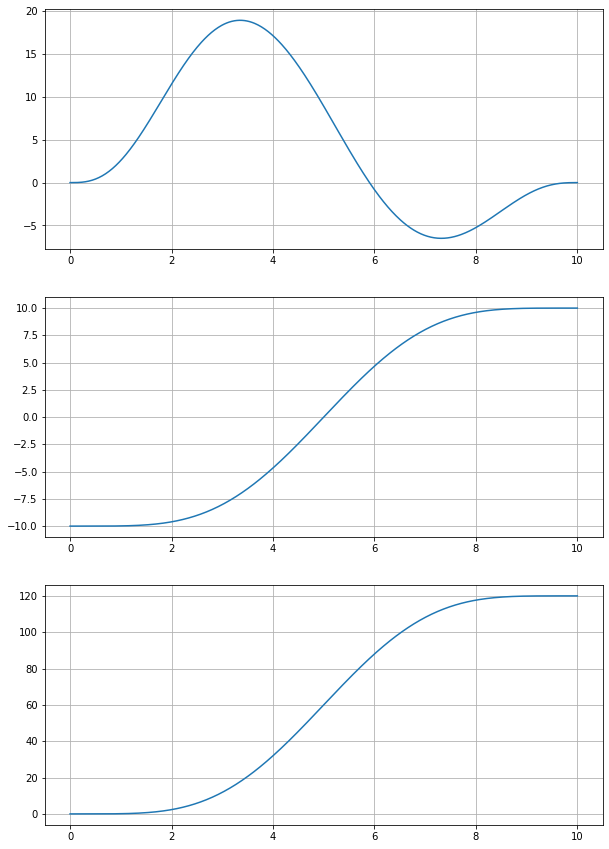

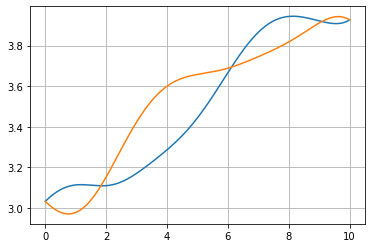

In [14]:
trajectory = traj_planner.generate()
deg = np.pi / 180
figure(figsize=(10, 15))
subplot(311)
plot(trajectory.t, trajectory.phi[:, 0] / deg)
grid()
subplot(312)
plot(trajectory.t, trajectory.eps[:, 0] / deg)
grid()
subplot(313)
plot(trajectory.t, trajectory.lamb[:, 0] / deg)
grid()

figure()
plot(trajectory.t, trajectory.vf)
plot(trajectory.t, trajectory.vb)
grid()
show()

In [2]:
# Pick and Place
def generate_pick_and_place(travel_distance=180, elevation_min=-20, elevation_max=20, move_time=20, pause_time=5, cycles=2, sample_rate=100):
    repeat_samples = pause_time * sample_rate
    
    forward_planner = TypePolynomialFlatness()
    forward_planner.elevation_start = elevation_min
    forward_planner.elevation_end = elevation_max
    forward_planner.travel_start = 0
    forward_planner.travel_end = travel_distance
    forward_planner.t_end = move_time
    forward_planner.sample_rate = sample_rate
    
    forward_traj = forward_planner.generate()
    
    reverse_planner = TypePolynomialFlatness()
    reverse_planner.elevation_start = elevation_max
    reverse_planner.elevation_end = elevation_min
    reverse_planner.travel_start = travel_distance
    reverse_planner.travel_end = 0
    reverse_planner.t_end = move_time
    reverse_planner.sample_rate = sample_rate
    
    reverse_traj = reverse_planner.generate()
    
    phi = np.zeros((0, 3))
    eps = np.zeros((0, 5))
    lamb = np.zeros((0, 5))
    vf = np.zeros((0, 1))
    vb = np.zeros((0, 1))
    
    for i in range(cycles):
        phi = np.append(phi, forward_traj.phi[:-1,:], axis=0)
        eps = np.append(eps, forward_traj.eps[:-1,:], axis=0)
        lamb = np.append(lamb, forward_traj.lamb[:-1,:], axis=0)
        vf = np.append(vf, forward_traj.vf[:-1,:], axis=0)
        vb = np.append(vb, forward_traj.vb[:-1,:], axis=0)
        
        phi = np.append(phi, np.repeat(forward_traj.phi[[-1],:], repeat_samples, axis=0), axis=0)
        eps = np.append(eps, np.repeat(forward_traj.eps[[-1],:], repeat_samples, axis=0), axis=0)
        lamb = np.append(lamb, np.repeat(forward_traj.lamb[[-1],:], repeat_samples, axis=0), axis=0)
        vf = np.append(vf, np.repeat(forward_traj.vf[[-1],:], repeat_samples, axis=0), axis=0)
        vb = np.append(vb, np.repeat(forward_traj.vb[[-1],:], repeat_samples, axis=0), axis=0)
        
        phi = np.append(phi, reverse_traj.phi[:-1,:], axis=0)
        eps = np.append(eps, reverse_traj.eps[:-1,:], axis=0)
        lamb = np.append(lamb, reverse_traj.lamb[:-1,:], axis=0)
        vf = np.append(vf, reverse_traj.vf[:-1,:], axis=0)
        vb = np.append(vb, reverse_traj.vb[:-1,:], axis=0)
        
        phi = np.append(phi, np.repeat(reverse_traj.phi[[-1],:], repeat_samples, axis=0), axis=0)
        eps = np.append(eps, np.repeat(reverse_traj.eps[[-1],:], repeat_samples, axis=0), axis=0)
        lamb = np.append(lamb, np.repeat(reverse_traj.lamb[[-1],:], repeat_samples, axis=0), axis=0)
        vf = np.append(vf, np.repeat(reverse_traj.vf[[-1],:], repeat_samples, axis=0), axis=0)
        vb = np.append(vb, np.repeat(reverse_traj.vb[[-1],:], repeat_samples, axis=0), axis=0)
    
    t = np.arange(phi.shape[0]) / sample_rate
    
    if max(np.max(np.abs(vf)), np.max(np.abs(vb))) > 5:
        print('Warning: Voltage limit reached')
    
    return Trajectory(t, phi, eps, lamb, vf, vb)

In [35]:
traj1 = generate_pick_and_place(move_time=20, pause_time=4)
traj2 = generate_pick_and_place(move_time=15, pause_time=3)
traj3 = generate_pick_and_place(move_time=10, pause_time=2)
traj4 = generate_pick_and_place(move_time=7.5, pause_time=1.5)

savemat("../matlab/trajectories/pnp_t20.mat", traj1.to_dict())
savemat("../matlab/trajectories/pnp_t15.mat", traj2.to_dict())
savemat("../matlab/trajectories/pnp_t10.mat", traj3.to_dict())
savemat("../matlab/trajectories/pnp_t7_5.mat", traj4.to_dict())


In [3]:
traj_only_eps = generate_pick_and_place(travel_distance=0, move_time=10)

savemat("../matlab/trajectories/pnp_eps_t10", traj_only_eps.to_dict())


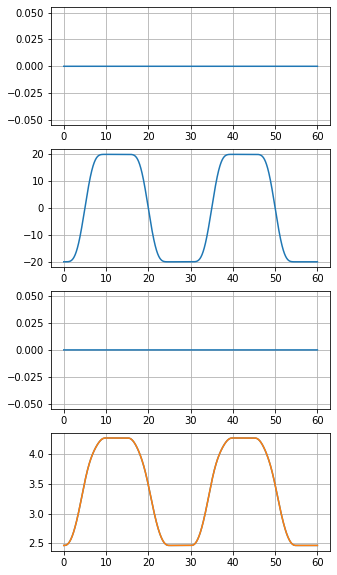

In [4]:
traj = traj_only_eps
deg = np.pi / 180
figure(figsize=(5, 10))

subplot(411)
plot(traj.t, traj.phi[:, 0] / deg)
grid()

subplot(412)
plot(traj.t, traj.eps[:, 0] / deg)
grid()

subplot(413)
plot(traj.t, traj.lamb[:, 0] / deg)
grid()

subplot(414)
plot(traj.t, traj.vf[:, 0])
plot(traj.t, traj.vb[:, 0])
grid()

In [40]:
traj_planner.generate().eps / np.pi * 180

array([[20.,  0.,  0.,  0.,  0.]])